In [1]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle
import collections
import scipy

import keras
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import matplotlib.pyplot as plt
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard


from functions_v2 import *

Using TensorFlow backend.


# Load Data

In [3]:
#### Lad Data
n = 100 

# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
#Read it with PIL as black and white and then change it to numpy array
imgs = [load_image(image_dir + files[i]) for i in range(n)]
# bw_imgs = [load_image_pil(image_dir + files[i], bw=True) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])



Loading 100 images
satImage_001.png
Loading 100 groundtruth
satImage_001.png


# Image whitening

(100, 64, 64, 3)


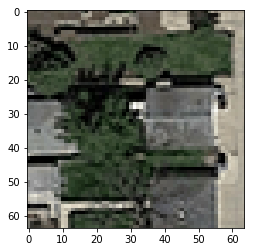

(100, 12288)
ZCA batch 1 out of 10
ZCA batch 2 out of 10
ZCA batch 3 out of 10
ZCA batch 4 out of 10
ZCA batch 5 out of 10
ZCA batch 6 out of 10
ZCA batch 7 out of 10
ZCA batch 8 out of 10
ZCA batch 9 out of 10
ZCA batch 10 out of 10

ZCA Matrix shape = (10, 10)


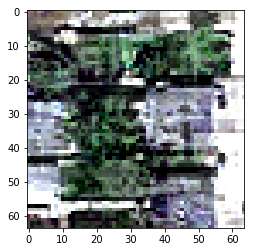

In [4]:

size = 64
n_batch = 10

ims = np.array(imgs[0:100])
ims = ims[:,0:size,0:size,:]
print(ims.shape)
show_ZCA(ims[0], size, size)
    
ZCAMatrix, zca = zca_whitening(ims, size, size, n_batch, bw = False)
show_ZCA(zca[0], size, size)



## X and Y
We create our training set.
- X : array of list of all patches
- Y : array of corresponding label

In [5]:
bw = False
patch_size = 16
padding = 24

if bw:
    images = sch_imgs
else:
    images = imgs

padded_images = pad_list_image(images, padding, bw)
patches = [get_patches(image, patch_size, patch_size, padding) for image in padded_images]
patches = [patch for image_patches in patches for patch in image_patches] # Flatten the array of patches to array of patch

gt_patches = [get_patches(gt_image, patch_size, patch_size, 0) for gt_image in gt_imgs]
gt_patches = [patch for image_patches in gt_patches for patch in image_patches] # Flatten (same thing)

print("There are", len(gt_patches), "patches")

There are 62500 patches


### Patch whitening

(62500, 12288)
ZCA batch 1 out of 20
ZCA batch 2 out of 20
ZCA batch 3 out of 20
ZCA batch 4 out of 20
ZCA batch 5 out of 20
ZCA batch 6 out of 20
ZCA batch 7 out of 20
ZCA batch 8 out of 20
ZCA batch 9 out of 20
ZCA batch 10 out of 20
ZCA batch 11 out of 20
ZCA batch 12 out of 20
ZCA batch 13 out of 20
ZCA batch 14 out of 20
ZCA batch 15 out of 20
ZCA batch 16 out of 20
ZCA batch 17 out of 20
ZCA batch 18 out of 20
ZCA batch 19 out of 20
ZCA batch 20 out of 20

ZCA Matrix shape = (3125, 3125)


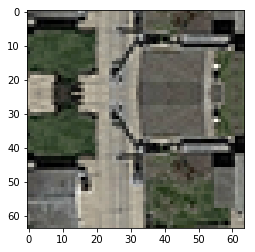

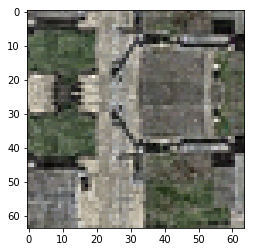

In [6]:
size = patch_size + 2*padding
zca_patches = []
ZCA_matrix = []
n_batch = 20



ZCAMatrix, zca_patches = zca_whitening(patches, size, size, n_batch)

show_ZCA(patches[100], size, size)
show_ZCA(zca_patches[100], size, size)



In [8]:
with open('ZCA_mat.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([ZCAMatrix], f)

### Real image patch against whitened

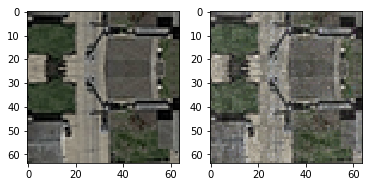

In [7]:

patch_index = 100

plt.subplot(1, 2, 1)
plt.imshow(patches[patch_index], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(zca_patches[patch_index], cmap='Greys_r');


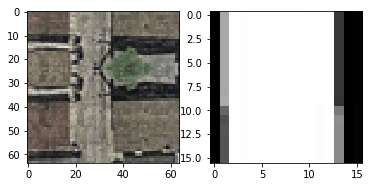

In [8]:

patch_index = 525

plt.subplot(1, 2, 1)
plt.imshow(zca_patches[patch_index], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(gt_patches[patch_index], cmap='Greys_r');


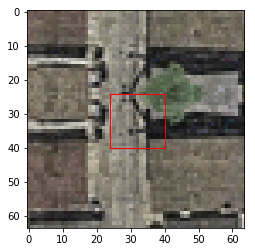

In [9]:
fig,ax = plt.subplots(1)
ax.imshow(zca_patches[patch_index])
rect = matplotlib_patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()


### X has only 2 dimensions in black and white, need to be 3D for the CNN
Change the dimension to (w,h,1)

In [10]:
X = np.array(zca_patches)
print(X.shape)
if bw:
    X = np.expand_dims(X, axis=3)
print(X.shape)
print(X[0])
Y_labels = np.array(list(map(lambda x: patch_to_label(x), gt_patches)))
Y_categorical = keras.utils.to_categorical(Y_labels, num_classes=2)

(62500, 64, 64, 3)
(62500, 64, 64, 3)
[[[ 0.24958675  0.2410501   0.22306612]
  [ 0.18941518  0.19936191  0.18293085]
  [ 0.18018937  0.16559235  0.17756057]
  ..., 
  [ 0.42699676  0.42661057  0.43942243]
  [ 0.41467901  0.4189464   0.4033741 ]
  [ 0.41336792  0.40385668  0.38057443]]

 [[ 0.2060081   0.18775288  0.19030846]
  [ 0.20917373  0.19561188  0.20003426]
  [ 0.15474893  0.15061691  0.18555211]
  ..., 
  [ 0.34723149  0.36408898  0.34587675]
  [ 0.28216136  0.29268719  0.26236911]
  [ 0.26539845  0.26662459  0.25057769]]

 [[ 0.20060441  0.18432149  0.18416668]
  [ 0.22144322  0.20336295  0.20473952]
  [ 0.2153388   0.20371663  0.20925493]
  ..., 
  [ 0.1754843   0.16696363  0.15378819]
  [ 0.34449124  0.33826702  0.31973886]
  [ 0.37482961  0.37461239  0.35622463]]

 ..., 
 [[ 0.28634658  0.32733575  0.24317643]
  [ 0.28272374  0.31518601  0.26229068]
  [ 0.25373915  0.28827288  0.22683503]
  ..., 
  [ 0.39191977  0.38472679  0.38995563]
  [ 0.45544905  0.43603273  0.4431697

#### Subsampling
There is more non-road than road patches in our dataset. We need to balance the set.

In [11]:
counter = collections.Counter(Y_labels)
count_to_keep = min(counter[0], counter[1])
print("There are", counter[0], "non-road patches")
print("There are", counter[1], "road patches")
print("Need to keep", count_to_keep, "patches")

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.array([0, 1]), Y_labels)
class_weight = dict(enumerate(class_weight))
class_weight

There are 46309 non-road patches
There are 16191 road patches
Need to keep 16191 patches


{0: 0.67481483081042559, 1: 1.9300846149095177}

In [52]:
# # Old instead use class weight
# X_balanced = []
# Y_balanced_labels = []
# road_count = 0
# non_road_count = 0
# for i in range(len(X)):
#     if Y_labels[i] == 1 and road_count < count_to_keep:
#         X_balanced.append(X[i])
#         Y_balanced_labels.append(Y_labels[i])
#         road_count += 1
#     elif Y_labels[i] == 0 and non_road_count < count_to_keep:
#         X_balanced.append(X[i])
#         Y_balanced_labels.append(Y_labels[i])
#         non_road_count += 1
        
# X_balanced = np.array(X_balanced)
# Y_balanced_labels = np.array(Y_balanced_labels)
# Y_balanced_categorical = keras.utils.to_categorical(Y_balanced_labels, num_classes=2)

In [12]:
# del bw_imgs
del patches
# del X_balanced
# del Y_balanced_labels
# del Y_balanced_categorical
# Save the ZCAMatrix as a pickle object


## Building the convolutional neural network

In [8]:


# input_shape = X[0].shape
input_shape = test_X[0].shape

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])




### Split to train and test

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.1, random_state=40)


In [17]:
batch_size = 64

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# datagen.fit(X)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

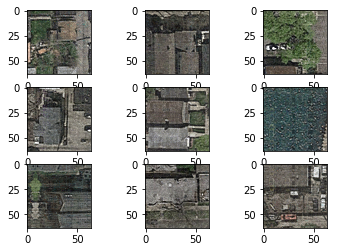

In [18]:
for X_batch, y_batch in train_generator:
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [19]:
epochs = 160

model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=879,
                    shuffle=True,
                    class_weight=class_weight,
                    callbacks=[TensorBoard(log_dir='/tmp/model')])


Epoch 1/160
879/879 [==============================] - 152s 173ms/step - loss: 0.6387 - acc: 0.6388
Epoch 2/160
879/879 [==============================] - 139s 159ms/step - loss: 0.5341 - acc: 0.7469
Epoch 3/160
879/879 [==============================] - 139s 159ms/step - loss: 0.4810 - acc: 0.7797
Epoch 4/160
879/879 [==============================] - 139s 159ms/step - loss: 0.4453 - acc: 0.7976
Epoch 5/160
879/879 [==============================] - 140s 159ms/step - loss: 0.4134 - acc: 0.8147
Epoch 6/160
879/879 [==============================] - 140s 159ms/step - loss: 0.3993 - acc: 0.8224
Epoch 7/160
879/879 [==============================] - 140s 159ms/step - loss: 0.3827 - acc: 0.8350
Epoch 8/160
879/879 [==============================] - 140s 159ms/step - loss: 0.3677 - acc: 0.8447
Epoch 9/160
879/879 [==============================] - 140s 160ms/step - loss: 0.3502 - acc: 0.8528
Epoch 10/160
879/879 [==============================] - 140s 160ms/step - loss: 0.3407 - acc: 0.8558

###  Save weights


In [20]:
model.save_weights("./weights/model_zca.h5")

###  Display a prediction vs ground truth



625/625 [==============================] - 12s 19ms/step


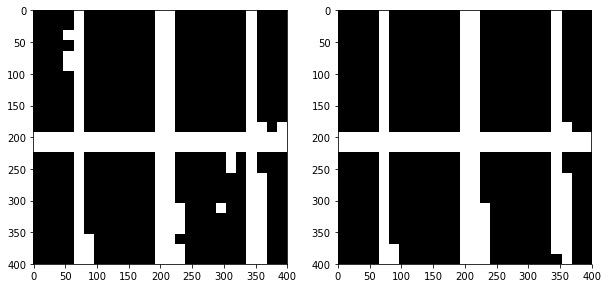

In [21]:
pred_img, gt_image = display_prediction_and_gt(model, X, Y_labels, 400, 16, 0)

In [22]:
predictions = model.predict_classes(X[:625 * 3])
save_labels_to_images(400, 400, patch_size, patch_size, predictions)

1875/1875 [==============================] - 25s 13ms/step
Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png


# Test

## Test data

In [23]:
# Free some memory
del predictions
del padded_images
# del patches
del zca_patches
del X
del Y_categorical
del Y_labels

In [2]:
TEST_IMG_SIZE = 608

In [3]:
test_dir = "datas/test_set_images/"
files = os.listdir(test_dir)
n = min(100, len(files))  # Load maximum 20 images
files.sort()
print("Loading " + str(n) + " images")
test_imgs = [load_image(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0]) for i in range(n)]
# bw_test_imgs = [load_image_pil(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0], bw=True) for i in range(n)]
print("Loaded !")

Loading 50 images
Loaded !


In [7]:
bw = False
patch_size = 16
padding = 24

if bw:
    images = sch_test_imgs
else:
    images = test_imgs

test_padded_images = pad_list_image(images, padding, bw)
test_patches = [get_patches(image, patch_size, patch_size, padding) for image in test_padded_images]
test_patches = [patch for image_patches in test_patches for patch in
                image_patches]  # Flatten the array of patches to array of patch

test_X = np.array(test_patches)

if bw:
    test_X = np.expand_dims(test_X, axis=3)
    
print(len(test_patches))
print(test_X.shape)

72200
(72200, 64, 64, 3)


### ZCA Whitening test
Load ZCA Whitening matrix and whiten test images

In [24]:
with open('ZCA_mat.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    ZCAMatrix = pickle.load(f)[0]

In [ ]:
def zca_whitening_test(images, h, w, n_batch, ZCA_mat, bw = False):
    """
    Function to compute ZCA whitening matrix .
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Get a batch size
    batch = int(len(images)/n_batch)
    
    # Convert the list into a numpy array
    images = np.array(images)
    
     # Flatten image
    if bw:
        images = images.reshape((-1,h*w))
    else:
        images = images.reshape((-1,h*w*3))
    
    print(images.shape)
        
    # 0 center the image
    images = images - images.mean(axis=0)
    # Global Contrast Normalization, which is quite often applied to image data. I'll use the L2 norm, which makes every image have vector magnitude 1:
    images = images / np.sqrt((images ** 2).sum(axis=1))[:,None]
    
    zca_ims = []
    for i in range(n_batch):
        if i == n_batch-1:
            # Get a batch of the images
            im_batch = images[batch*i:]

            #Data whitening
            zca = np.dot(ZCAMatrix[0:im_batch.shape[0],0:im_batch.shape[0]], im_batch)   
        else:
            # Get a batch of the images
            im_batch = images[batch*i:(i+1)*batch]

            #Data whitening
            zca = np.dot(ZCAMatrix, im_batch)   

        # Turn into values between 0 and 1
        m,M = zca.min(axis=0), zca.max(axis=0)
        zca = (zca - m) / (M - m)

        # Return the image to its shape
        if bw:
            zca = zca.reshape((-1,h,w,1))
        else:
            zca = zca.reshape((-1,h,w,3))
        
        zca_ims.append(zca)
        
    # Unlist the small lists to make a unique list of the whitened images
    flat_zca = [item for sublist in zca_ims for item in sublist]
  
    return flat_zca

n_batch = int(np.ceil(len(test_patches)/ZCAMatrix.shape[0]))
test_X = zca_whitening_test(test_X, size, size, n_batch, ZCAMatrix)

(72200, 12288)


###  Load existing weights


In [ ]:

model.load_weights("./weights/model_zca.h5")


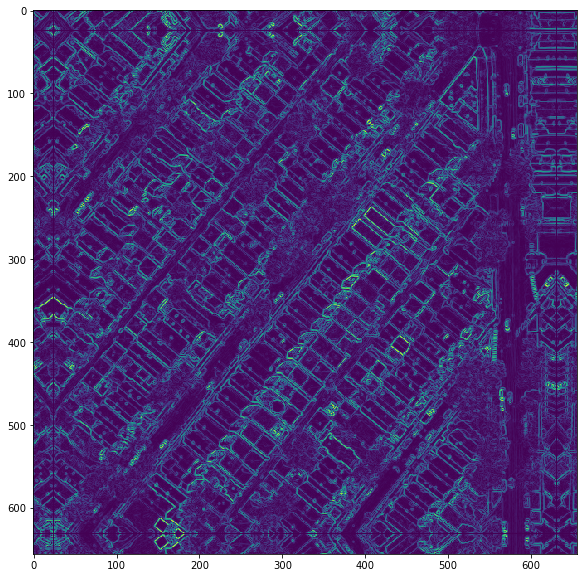

1444/1444 [==============================] - 2s 1ms/step


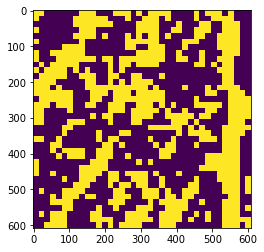

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(test_padded_images[len(test_padded_images) - 1]);
plt.show()
test_label = label_to_img(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, model.predict_classes(test_X[-1444:]))
plt.imshow(test_label);

In [32]:
predictions = model.predict_classes(test_X)
save_labels_to_images(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, predictions)


72200/72200 [==============================] - 51s 712us/step
Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png
Saving predictions/prediction_4.png
Saving predictions/prediction_5.png
Saving predictions/prediction_6.png
Saving predictions/prediction_7.png
Saving predictions/prediction_8.png
Saving predictions/prediction_9.png
Saving predictions/prediction_10.png
Saving predictions/prediction_11.png
Saving predictions/prediction_12.png
Saving predictions/prediction_13.png
Saving predictions/prediction_14.png
Saving predictions/prediction_15.png
Saving predictions/prediction_16.png
Saving predictions/prediction_17.png
Saving predictions/prediction_18.png
Saving predictions/prediction_19.png
Saving predictions/prediction_20.png
Saving predictions/prediction_21.png
Saving predictions/prediction_22.png
Saving predictions/prediction_23.png
Saving predictions/prediction_24.png
Saving predictions/prediction_25.png
Saving predictions/pre